In [59]:
import pandas as pd
from scipy.stats import spearmanr
import numpy as np
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from scipy import stats
import ast 

In [60]:
categories = ['banana','beach','car','church','lighthouse','mountain','mug','plane']
path='../Analysis/human_rating_bycat'

In [61]:
for i, cate in enumerate(categories):
    col = [cate+'_'+str(i+1) for i in range(16)]
    new = pd.read_csv(path+'/'+cate+'.csv')
    new.columns = col
    if i == 0:
        old = new
    else:
        old = pd.concat([old,new],axis=1)
df = old

(Test) Use quantiles to remove outliers 

In [62]:
quantile_low = df.quantile(0.1)
quantile_high = df.quantile(0.9)
iqr = quantile_high - quantile_low

In [63]:
outliers = (df < quantile_low) | (df > quantile_high)
df_new = df[outliers.sum(axis=1) <= 12]

Compute 7 scorse and sort images by order in survey

In [65]:
# alexnet_df=pd.read_csv('alexnet_scores_wordnet_id_closest_label.csv',index_col=0)
# alexnet_df['typicality_score'] = np.round(alexnet_df['closest_prob'] * 100,2)
# alexnet_df['7_score']= np.round(alexnet_df['typicality_score']*7/100,2)
# alexnet_df['type'] = alexnet_df['type'].apply(lambda x: x.lower())

# alexnet_df=pd.read_csv('alexnet_scores_wordnet_id_matched_label.csv',index_col=0)
# alexnet_df['typicality_score'] = np.round(alexnet_df['matched_prob'] * 100,2)
# alexnet_df['7_score']= np.round(alexnet_df['typicality_score']*7/100,2)
# alexnet_df['type'] = alexnet_df['type'].apply(lambda x: x.lower())

alexnet_df=pd.read_csv('alexnet_scores_final_with_raw.csv',index_col=0)
alexnet_df['typicality_score'] = np.round(alexnet_df['prob'] * 100,2)
# alexnet_df['7_score']= np.round(alexnet_df['typicality_score']*7/100,2)
alexnet_df['type'] = alexnet_df['type'].apply(lambda x: x.lower())

In [66]:
alexnet_df['number'] = alexnet_df['dir'].apply(lambda x: int(x.split('\\')[-1].split('.')[0]))
alexnet_df = alexnet_df.sort_values(['type','number']).reset_index(drop=True)

In [67]:
# alexnet_df['readable_labels'].apply(lambda x: ast.literal_eval(x)[list(ast.literal_eval(x).keys())[0]])

array(['banana', 'beach', 'car', 'church', 'lighthouse', 'mountain',
       'mug', 'plane'], dtype=object)

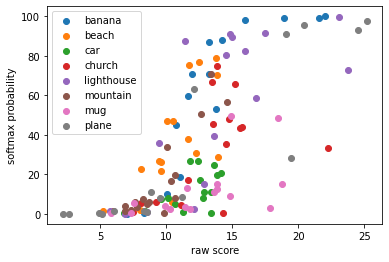

In [80]:
for cate in alexnet_df['type'].unique():
    plt.scatter(alexnet_df['raw'][alexnet_df['type']==cate], alexnet_df['typicality_score'][alexnet_df['type']==cate],label = cate)
plt.xlabel('raw score')
plt.ylabel('softmax probability')
plt.legend()
plt.show()

# Correlation with human ratings

Changes from original script: 
1. Use spearman rank correlation instead of pearson
2. Compute average human ratings first, and then compute correlation with neural net typicality scores

without dropping outliers

In [73]:
final_corr = dict()
for t in np.unique(alexnet_df['type']):
    col_names = [t + '_' + str(i+1) for i in range(16)]
    human_ratings = df[col_names] 
    net_ratings = alexnet_df[alexnet_df['type'] == t] 
    
    human_scores = human_ratings.mean().values
#     net_scores = net_ratings['readable_labels'].apply(lambda x: ast.literal_eval(x)[list(ast.literal_eval(x).keys())[0]]).values
#     net_scores = net_ratings['7_score'].values # both get worse scores

#     net_scores = net_ratings['typicality_score'].values
    net_scores = net_ratings['raw'].values
        
    coef, p=stats.spearmanr(human_scores, net_scores)
#     coef, p=stats.pearsonr(human_scores, net_scores)
    final_corr[t]=coef
    print(f'{t}: ', final_corr[t])

banana:  0.5710082487741024
beach:  -0.044117647058823525
car:  0.3852941176470588
church:  0.3929360887182612
lighthouse:  0.2911764705882353
mountain:  0.4665196259314187
mug:  0.3711344231148904
plane:  0.7255336769217332


In [74]:
print(np.mean(list(final_corr.values())))

0.3949356255796096


after dropping outliers

In [75]:
final_corr = dict()
for t in np.unique(alexnet_df['type']):
    col_names = [t + '_' + str(i+1) for i in range(16)]
    
    human_ratings = df_new[col_names] 
    net_ratings = alexnet_df[alexnet_df['type'] == t] 
    
    human_scores = human_ratings.mean().values
#     net_scores = net_ratings['typicality_score'].values
    net_score = net_ratings['raw'].values
    coef, p=stats.spearmanr(human_scores, net_scores)
#     coef, p=stats.pearsonr(human_scores, net_scores)
    final_corr[t]=coef
    print(f'{t}: ', final_corr[t])

banana:  0.32229589299362993
beach:  0.34757033275838933
car:  -0.07511053801134686
church:  -0.005886682977052602
lighthouse:  0.6215028831527133
mountain:  0.20163754128832556
mug:  -0.42478060920777444
plane:  0.693218355304354


In [76]:
print(np.mean(list(final_corr.values())))

0.21005589691265478
